In [1]:
# sys
import os
import os.path as op
import sys

# basics
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import plot_sat, sat, io
from lib.config import *

# warnings
import warnings
warnings.filterwarnings("ignore")

# Selection of CFOSAT passes over the ESTELA area

These notebooks show how the combination of 2D wave spectra from SWIM on-board instrument acquired over user-defined area and time extent, can be used for the observation and forecast of ocean swell fields reaching a target location. 

Mean wave parameters obtained from the integration of the pointing-sector SWIM wave slope spectrum are used to propagate forewards the energy

Evaluation of Source of wave Energy reaching a Local Area method from Perez et al., (2014), identifies the relevant amount of energy directed along great circle arcs toward the study site using the partitioned wave spectra from CAWCR hindcast at a global scale

In [2]:
print('Forecast Day: {0} based on the last {1} days'.format(forecast_day, n_days))

Forecast Day: 2021-01-15 00:00:00 based on the last 10 days


## Mask evaluation soure

In [3]:
est = xr.open_dataset(op.join(p_data,'Estela_samoa.nc'), decode_times=False)

est = est.sel(time='ALL')
est = est.assign({'estela_mask':(('latitude','longitude'),np.where(est.F.values>0,1,np.nan))})
estela_mask = est.estela_mask # mask for slp

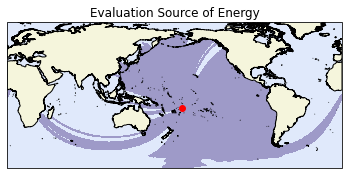

In [4]:
figsize = (25,15)
figsize = None
title = 'Evaluation Source of Energy'
fig, ax = plot_sat.estela_map(figsize, title, estela_mask)

## Select last days passes

In [5]:
dayYear = forecast_day.strftime('%j')

In [6]:
files_sort = np.sort(os.listdir(sat_cfosat))
p = np.where(files_sort == dayYear)[0][0]
folders = [op.join(sat_cfosat, i) for i in files_sort[p - n_days:p]]
files = [os.listdir(fdi) for fdi in folders]
files = np.concatenate(files)
df_data = io.load_files(files)

## Load satellite track time-lags and starting time

In [7]:
offs = io.load_timelags(estela_mask)

In [8]:
tracks = io.load_tracks()

In [9]:
tracks

cycle RE
time                         
2020-10-16 10:16:59     56  E
2020-10-29 10:16:59     57  E
2020-11-11 10:16:59     58  E
2020-11-24 10:16:59     59  E
2020-12-07 10:16:59     60  E
2020-12-20 10:16:59     61  E
2021-01-02 10:16:59     62  E

## Obtain the pass over date & time

In [10]:
# We obtain the pass over date & time by adding the T0 value
ixs = []
for pi, t_cycle in enumerate(tracks.index.values):
    for pj, t_off in enumerate(offs):
        time = t_cycle + np.array([t_off], dtype="timedelta64[ms]")[0]
        sel_files = df_data.loc[np.where((df_data.dates_st < time) & (df_data.dates_ed > time))]

        if len(sel_files) > 0:
            ixs.append(sel_files.index.values[0])

ixs = np.sort(np.unique(ixs))
print('Files found\n')
print(df_data['name'][ixs].head())

Files found

1    CFO_OP05_SWI_L2_____F_20210101T094852_20210101...
2    CFO_OP05_SWI_L2_____F_20210101T160055_20210101...
3    CFO_OP05_SWI_L2_____F_20210101T001253_20210101...
4    CFO_OP05_SWI_L2_____F_20210101T143637_20210101...
5    CFO_OP05_SWI_L2_____F_20210101T125424_20210101...
Name: name, dtype: object


In [11]:
df_sel = df_data.loc[ixs]
df_sel.to_pickle(op.join(p_data, 'CFO_region.pkl'))
df_sel

name            dates_st  \
1    CFO_OP05_SWI_L2_____F_20210101T094852_20210101... 2021-01-01 09:48:52   
2    CFO_OP05_SWI_L2_____F_20210101T160055_20210101... 2021-01-01 16:00:55   
3    CFO_OP05_SWI_L2_____F_20210101T001253_20210101... 2021-01-01 00:12:53   
4    CFO_OP05_SWI_L2_____F_20210101T143637_20210101... 2021-01-01 14:36:37   
5    CFO_OP05_SWI_L2_____F_20210101T125424_20210101... 2021-01-01 12:54:24   
..                                                 ...                 ...   
164  CFO_OP05_SWI_L2_____F_20210114T033201_20210114... 2021-01-14 03:32:01   
166  CFO_OP05_SWI_L2_____F_20210114T052713_20210114... 2021-01-14 05:27:13   
167  CFO_OP05_SWI_L2_____F_20210114T112138_20210114... 2021-01-14 11:21:38   
168  CFO_OP05_SWI_L2_____F_20210114T200131_20210114... 2021-01-14 20:01:31   
169  CFO_OP05_SWI_L2_____F_20210114T081531_20210114... 2021-01-14 08:15:31   

               dates_ed  
1   2021-01-01 11:21:42  
2   2021-01-01 17:12:55  
3   2021-01-01 01:46:14  
4   2021-01-01 16:00:56  
5   2021-01-01 14:36:38  
..                  ...  
164 2021-01-14 05:06:46  
166 2021-01-14 06:41:34  
167 2021-01-14 12:54:21  
168 2021-01-14 20:52:53  
169 2021-01-14 09:48:49  

[139 rows x 3 columns]